In [0]:
# IMPORTING SOME LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy
import random
import math
import time
import datetime
import operator

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBClassifier
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
!pip install distance
import distance
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()


import plotly.express as px
import plotly.graph_objects as go


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


     |████████████████████████████████| 184kB 3.5MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=7dfd1d431a27972fd9e2ca291b2802f6baffbaec42274321381f4ee227f1b4e1
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train=pd.read_csv('/content/drive/My Drive/Quora Question Pair/train1.csv')
print('Shape of the data:',df_train.shape)
df_train.head()

Shape of the data: (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


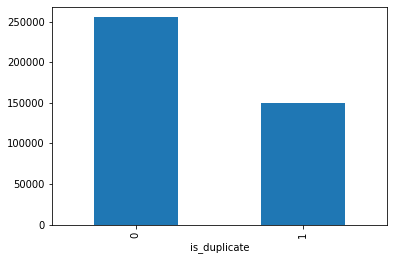

In [0]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



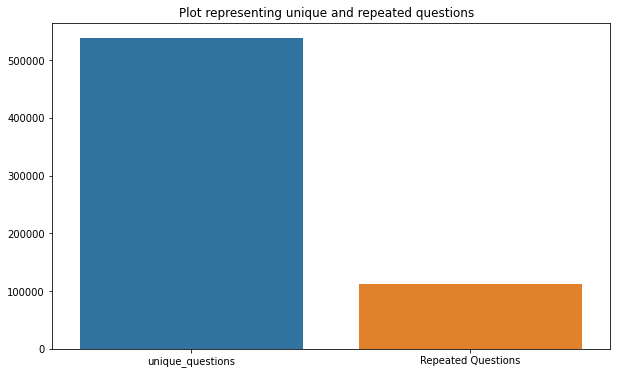

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

Maximum number of times a single question is repeated: 157



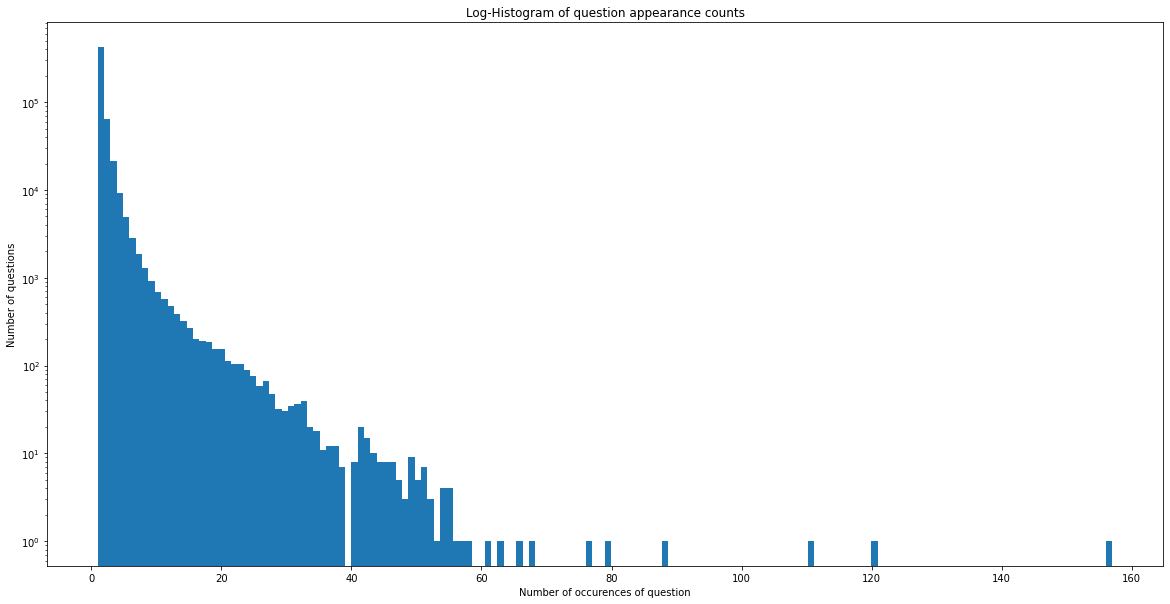

In [0]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [0]:
df_test=pd.read_csv('/content/drive/My Drive/Quora Question Pair/test.csv')
print('Shape of the data:',df_test.shape)
df_test.head()

Shape of the data: (2345796, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [0]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)


(-0.5, 1439.5, 1079.5, -0.5)

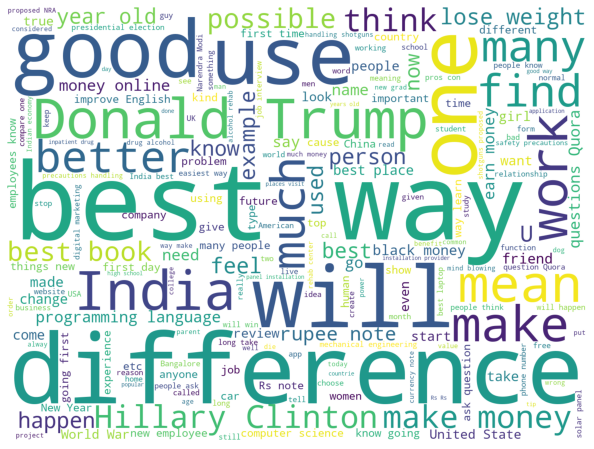

In [0]:
from wordcloud import WordCloud
cloud = WordCloud(background_color='white',width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(15, 8))
plt.imshow(cloud)
plt.axis('off')

In [0]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text(0.5, 0, 'word_match_share')

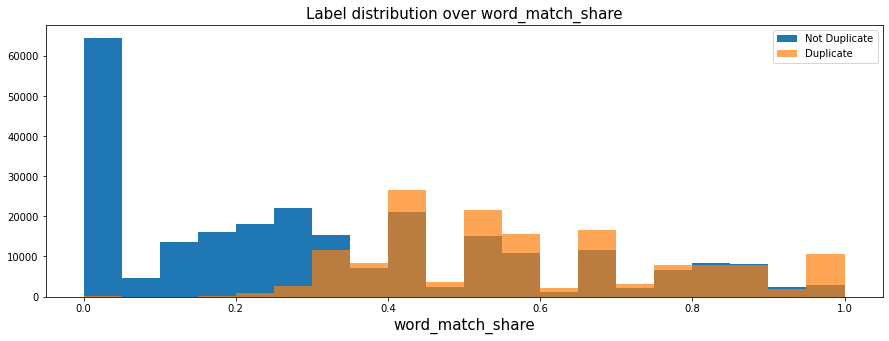

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [0]:
df_train=df_train.fillna(' ')

In [0]:
df_train.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [0]:
df1=df_train
df1

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [0]:
df1['freq_qid1'] = df1.groupby('qid1')['qid1'].transform('count') 
df1['freq_qid2'] = df1.groupby('qid2')['qid2'].transform('count')
df1['q1len'] = df1['question1'].str.len() 
df1['q2len'] = df1['question2'].str.len()
df1['q1_n_words'] = df1['question1'].apply(lambda row: len(row.split(" ")))
df1['q2_n_words'] = df1['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)
df1['word_Common'] = df1.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * (len(w1) + len(w2))
df1['word_Total'] = df1.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df1['word_share'] = df1.apply(normalized_word_share, axis=1)

df1['freq_q1+q2'] = df1['freq_qid1']+df1['freq_qid2']
df1['freq_q1-q2'] = abs(df1['freq_qid1']-df1['freq_qid2'])

In [0]:
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
SAFE_DIV = 0.0001  #saving from dividing by 0.

def createAdvancedFeatures(ques1, ques2):
    featureValues = [0.0]*11
    
    ques1_words = ques1.split()
    ques2_words = ques2.split()
    
    if len(ques1_words) == 0 or len(ques2_words) == 0:
        return featureValues
    
    ques1_words_set = set(ques1.split())
    ques2_words_set = set(ques2.split())
    
    featureValues[0] = len(ques1_words_set.intersection(ques2_words_set)) / (min(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[1] = len(ques1_words_set.intersection(ques2_words_set)) / (max(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[2] = int(ques1_words[-1] == ques2_words[-1])
    featureValues[3] = int(ques1_words[0] == ques2_words[0])
    featureValues[4] = abs(len(ques1_words) - len(ques2_words))
    featureValues[5] = (len(ques1_words) + len(ques2_words))/2
    featureValues[6] = fuzz.ratio(ques1, ques2)
    featureValues[7] = fuzz.partial_ratio(ques1, ques2)
    featureValues[8] = fuzz.token_sort_ratio(ques1, ques2)
    featureValues[9] = fuzz.token_set_ratio(ques1, ques2)
    
    strs = list(distance.lcsubstrings(ques1, ques2)) # https://github.com/doukremt/distance/blob/master/distance/_lcsubstrings.py
    if len(strs) == 0:
        featureValues[10] = 0
    else:
        featureValues[10] = len(strs[0]) / (min(len(ques1), len(ques1)) + SAFE_DIV)
        
    return featureValues

In [0]:
advFeatures = df1.apply(lambda x: createAdvancedFeatures(x["question1"], x["question2"]), axis=1)

df1["CWC_Min"] = list(map(lambda x: x[0], advFeatures))
df1["CWC_Max"] = list(map(lambda x: x[1], advFeatures))
df1["Last_Word_Equality"] = list(map(lambda x: x[2], advFeatures))
df1["First_Word_Equality"] = list(map(lambda x: x[3], advFeatures))
df1["Abs_Len_Diff"] = list(map(lambda x: x[4], advFeatures))
df1["Mean_Len"] = list(map(lambda x: x[5], advFeatures))
df1["Fuzz_Ratio"] = list(map(lambda x: x[6], advFeatures))
df1["Fuzz_Partial_Ratio"] = list(map(lambda x: x[7], advFeatures))
df1["Token_Sort_Ratio"] = list(map(lambda x: x[8], advFeatures))
df1["Token_Set_Ratio"] = list(map(lambda x: x[9], advFeatures))
df1["Longest_Substr_Ratio"] = list(map(lambda x: x[10], advFeatures))

df1.fillna("")
#data_new.to_csv(os.path.join(DATAPATH, DATA_ADV), index = False)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,2,2,85,79,14,13,11.0,25.0,0.440000,4,0,0.749994,0.692302,1.0,1.0,1.0,13.5,87.0,84.0,88.0,97.0,0.364705
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,12,1,41,42,8,9,5.0,16.0,0.312500,13,11,0.624992,0.555549,1.0,0.0,1.0,8.5,72.0,76.0,69.0,79.0,0.658535
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1,1,17,17,4,3,1.0,7.0,0.142857,2,0,0.333322,0.249994,1.0,0.0,1.0,3.5,76.0,76.0,75.0,75.0,0.352939
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1,1,94,127,17,25,1.0,40.0,0.025000,2,0,0.058823,0.043478,0.0,0.0,8.0,21.0,30.0,34.0,35.0,37.0,0.053191


In [0]:
df1.to_csv('/content/drive/My Drive/Quora Question Pair/train_preprocessed.csv')


In [0]:
df_1=df1

In [0]:
labels = df1['is_duplicate'].values
df_1=df_1.drop(['freq_qid1','freq_qid2','id','qid1','qid2','question1','question2','is_duplicate'],axis=1)
df_1

,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484
1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980
2,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288
3,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000
4,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,85,79,14,13,11.0,25.0,0.440000,4,0,0.749994,0.692302,1.0,1.0,1.0,13.5,87.0,84.0,88.0,97.0,0.364705
404286,41,42,8,9,5.0,16.0,0.312500,13,11,0.624992,0.555549,1.0,0.0,1.0,8.5,72.0,76.0,69.0,79.0,0.658535
404287,17,17,4,3,1.0,7.0,0.142857,2,0,0.333322,0.249994,1.0,0.0,1.0,3.5,76.0,76.0,75.0,75.0,0.352939
404288,94,127,17,25,1.0,40.0,0.025000,2,0,0.058823,0.043478,0.0,0.0,8.0,21.0,30.0,34.0,35.0,37.0,0.053191


In [0]:
import xgboost as xgb
X = df_1
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.9388154875211496
validation score: 0.8045763517938862
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     83975
           1       0.77      0.73      0.75     49441

    accuracy                           0.82    133416
   macro avg       0.81      0.80      0.80    133416
weighted avg       0.82      0.82      0.82    133416



In [0]:
df2=pd.read_csv('/content/drive/My Drive/Quora Question Pair/train1.csv')

In [0]:
df2['question1'] = df2['question1'].apply(lambda x: str(x))
df2['question2'] = df2['question2'].apply(lambda x: str(x))
df2.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df2['question1']) + list(df2['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df2['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df2['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [1:04:50<00:00, 103.92it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(df2['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df2['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:05:06<00:00, 103.49it/s]


In [0]:
df=pd.read_csv('/content/drive/My Drive/Quora Question Pair/train1.csv')
df = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df

,id
0,0
1,1
2,2
3,3
4,4
...,...
404285,404285
404286,404286
404287,404287
404288,404288


In [0]:
df3_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist(), index= df.index)

In [0]:
print(df1.shape)
df1.head()

(404290, 28)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947


In [0]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466

In [0]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-14.616981,59.755488,-53.263745,19.514497,113.916473,101.657056,8.561499,66.232769,32.888127,210.812733,-14.521656,5.732026,40.648458,-95.787979,-1.157125,-66.563451,-31.051373,-17.968147,-30.063745,32.889709,65.430540,54.742656,1.756501,27.786168,-46.373962,-25.822312,51.231668,-20.655695,98.152685,-96.048390,126.935466,-28.066691,82.523253,-91.751655,-24.696691,-67.690101,171.840663,-62.797236,-22.777055,-60.322768,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,-3.565742,-16.844571,-130.911785,0.320254,79.350278,23.562028,79.124551,84.119839,128.684135,279.539877,51.329233,-47.977027,124.322700,-106.766716,-35.756386,-119.277429,21.692362,79.320570,-30.874480,-86.451965,-75.311001,-10.504030,-54.459205,-82.283126,-122.537507,-23.897150,38.062149,-120.668866,96.555255,-172.800629,71.174992,52.399280,-3.790546,-88.446559,-1.359644,-169.229485,242.162139,-106.348765,-118.454241,-81.356276,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,156.833630,59.991896,-8.414311,29.251426,133.680218,112.457566,89.849781,21.613022,24.331766,171.114490,-104.683288,-27.202060,-45.827002,-96.844532,-12.986917,43.818585,20.793440,15.393396,0.015373,-28.024086,-12.633978,11.869804,-52.478160,-3.826736,8.331102,21.353006,-36.579113,-14.109747,43.868416,-107.133660,125.654210,-0.800086,39.060021,-50.904144,37.683092,-78.781466,122.383833,-67.524980,-107.706957,-19.469239,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,41.472439,56.717317,31.530616,-5.520164,33.454800,79.596179,15.508996,40.042066,21.094017,101.998116,-70.692718,-62.091010,-21.603829,-52.963033,-6.126429,23.129693,-39.828342,-7.557531,10.800786,12.595844,32.663719,-36.700902,-20.552382,-7.180278,-32.160210,28.720635,-42.108100,-63.517539,36.148466,3.026077,-8.988254,64.167554,33.157036,-21.770225,-14.935299,0.127441,61.023365,-50.604968,-81.644456,-43.092263,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,-14.446975,-4.338255,-70.196208,-48.636382,18.356858,-50.807069,24.311196,60.043674,32.421993,57.148702,-39.954876,-1.186079,103.167159,-60.704754,8.761264,27.956269,11.443861,-44.191169,-44.108188,49.248302,18.939539,29.493630,-19.378594,3.728311,-41.595879,6.727060,46.843683,-32.771427,52.378441,-32.777207,73.263024,12.407717,35.007572,-44.449785,-1.699862,-68.

In [0]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df3_q1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,id
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916,0
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543,1
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161,2
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932,3
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466,-18.022328,-90.972944,67.553356,-

In [0]:
df2  = df3_q1.merge(df3_q2, on='id',how='left')
df2

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376

In [0]:
result  = df1.merge(df2, on='id',how='left')

In [0]:
result

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,...,71.499781,18.965061,-51.951589,143.003627,80.452

In [0]:
result.to_csv('/content/drive/My Drive/Quora Question Pair/final_preprocessed.csv')


In [0]:
df_train=pd.read_csv('/content/drive/My Drive/Quora Question Pair/final_preprocessed.csv')
print('Shape of the data:',df_train.shape)
df_train.head()

Shape of the data: (404290, 221)


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53

In [0]:
df=df_train

In [0]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=221)


In [0]:
labels = df['is_duplicate'].values
df=df.drop(['Unnamed: 0','freq_qid1','freq_qid2','id','qid1','qid2','question1','question2','is_duplicate'],axis=1)
df

,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,66,57,14,12,10.0,23.0,0.434783,2,0,0.909083,0.833326,0.0,1.0,2.0,13.0,93.0,98.0,93.0,100.0,0.848484,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,51,88,8,13,4.0,20.0,0.200000,5,3,0.499994,0.333331,0.0,1.0,5.0,10.5,65.0,73.0,63.0,86.0,0.450980,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,73,59,14,10,4.0,24.0,0.166667,2,0,0.299997,0.214284,0.0,1.0,4.0,12.0,45.0,41.0,63.0,63.0,0.123288,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.0,0.0,2.0,10.0,7.0,20.0,24.0,28.0,0.040000,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,76,39,13,7,2.0,20.0,0.100000,4,2,0.285710,0.153845,0.0,1.0,6.0,10.0,37.0,54.0,47.0,67.0,0.078947,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,...,71.499781,18.965061,-51.951589,143.003627,80.452054,-68.287474,57.275702,36.489817,53.253386,-27.336291,47.700427,-49.834492,-73.123519,55.578373,16.308465,-11.157177,-36.426174,-22.066498,-44.440222,5

In [0]:
import xgboost as xgb
X = df
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.9983139387779605
validation score: 0.8208854448528047
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     83975
           1       0.79      0.75      0.77     49441

    accuracy                           0.83    133416
   macro avg       0.83      0.82      0.82    133416
weighted avg       0.83      0.83      0.83    133416



In [0]:
from sklearn.metrics import accuracy_score
print('Accuracy Score :',accuracy_score(y, xgb_model.predict(X))) 

Accuracy Score : 0.9444656063716639


In [0]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y, xgb_model.predict(X))

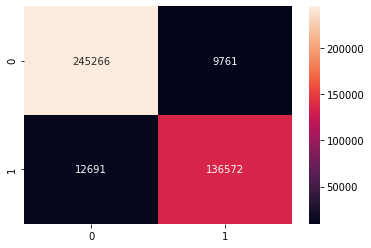

In [0]:
sns.heatmap(cm, annot=True, fmt="d")
plt.show()